In [1]:
import os
import time
import librosa
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange,tqdm
import scipy


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearnex import patch_sklearn, config_context

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd() + "/STFT_npy_dataset/"
path

'D:\\Study\\Code\\Python\\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset/'

In [3]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

D:\Study\Code\Python\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset//train
D:\Study\Code\Python\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset//val
D:\Study\Code\Python\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset//test


In [4]:
def data_loader(path):
    X = []
    Y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X += feature.tolist()
            Y += [label]*feature.shape[0]
    return X, Y

In [5]:
X_train, Y_train = data_loader(TRAINING_DIR)
X_val, Y_val = data_loader(VALIDATION_DIR)
X_test, Y_test = data_loader(TEST_DIR)

In [6]:
print("There are {} training samples and {} training labels".format(len(X_train), len(Y_train)))
print("There are {} validation samples and {} validation labels".format(len(X_val), len(Y_val)))
print("There are {} testing samples and {} testing labels".format(len(X_test), len(Y_test)))

There are 14000 training samples and 14000 training labels
There are 2000 validation samples and 2000 validation labels
There are 4000 testing samples and 4000 testing labels


In [7]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_val: {}".format(Y_val.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (14000, 1026)
Shape of X_val: (2000, 1026)
Shape of X_test: (4000, 1026)
Shape of Y_train: (14000,)
Shape of Y_val: (2000,)
Shape of Y_test: (4000,)


In [8]:
X_test = np.vstack((X_test, X_val))
Y_test = np.hstack((Y_test, Y_val))
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))


print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (14000, 1026)
Shape of X_test: (6000, 1026)
Shape of Y_train: (14000, 1)
Shape of Y_test: (6000, 1)


In [9]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [10]:
# shuffle_index = np.random.permutation(len(X_train))
# X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]
# shuffle_index = np.random.permutation(len(X_test))
# X_test, Y_test = X_test[shuffle_index], Y_test[shuffle_index]

In [11]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)
np.unique(Y_test)

array([0, 1])

In [12]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
print(X_train.shape)
print(X_train[0:5,:])

(14000, 1026)
[[ 1.97348117e-01  9.77980475e-02  5.57847930e-02 ...  1.15017633e-01
   8.38334518e-02  1.02181118e-01]
 [-3.62935505e-01 -3.75841849e-01 -4.26281223e-01 ... -6.78658549e-02
  -1.08136253e-04  1.77375795e-01]
 [ 1.63248338e-01  3.03584561e-02  5.73737868e-01 ... -4.13452996e-02
  -2.17979827e-02  2.99184299e-02]
 [ 6.87676792e-02 -2.30697766e-01 -4.15565758e-01 ... -1.31236353e-01
   1.62681476e-01  1.84707110e-01]
 [-4.27410644e-01 -4.11749031e-01 -1.79949877e-01 ... -2.50431383e-01
  -2.47825836e-01 -2.10453717e-01]]


In [13]:
SEED = 1337

In [14]:
# global cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=SEED)
# global X_train, Y_train, X_test, Y_test

In [15]:
def search_for_best_models(model, parameter_search, X_train, Y_train, X_test, Y_test, scoring='accuracy', verbose=3):
    search = RandomizedSearchCV(model, parameter_search, n_iter=10, scoring=scoring, verbose = verbose, n_jobs=1, random_state=SEED)
    first_time = time.time()
    search.fit(X_train, Y_train) 
    second_time = time.time()
    best_model = search.best_estimator_
    optimal_params = search.best_params_
    Y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    time_training = second_time - first_time
    

    print("Model: {}".format(model.__class__.__name__))
    print("Best parameters: {}".format(search.best_params_))
    print("Best cross-validation score: {:.2f}".format(search.best_score_))
    print("Test set score: {:.2f}".format(accuracy))
    print("Time training: ", time_training,"s")    
    print("-"*50)

    return best_model, search, accuracy, optimal_params, time_training

In [16]:
patch_sklearn()

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)] # Nhiều quá -> 100, 200, 500, 1000, 2000
n_estimators = [100, 200, 500, 1000, 2000]
max_features = [2, 4, 5 ,9, 10, 15, 18] #Trong bai cua co la 2, 4, 5 ,9, 10, 15, 18
min_samples_split = [2, 5, 11] # Trong bai la 5, 11 #Nên lấy số lẻ

# max_depth = [int(x) for x in np.linspace(5, 110, num = 22)] -> 2, 5, 8, 10, None
max_depth = [2, 5, 8, 10,] #-> 2, 5, 8, 10, None
max_depth.append(None)
criterion = ['gini', 'entropy', 'log_loss']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
parameter_search = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion
}
original_model = RandomForestClassifier(random_state = SEED)
best_model, search, accuracy, optimal_params, time_training = search_for_best_models(original_model, parameter_search, X_train, Y_train, X_test, Y_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, criterion=log_loss, max_depth=2, max_features=4, min_samples_leaf=2, min_samples_split=11, n_estimators=1000;, score=0.534 total time=  33.4s
[CV 2/5] END bootstrap=True, criterion=log_loss, max_depth=2, max_features=4, min_samples_leaf=2, min_samples_split=11, n_estimators=1000;, score=0.698 total time=  33.5s
[CV 3/5] END bootstrap=True, criterion=log_loss, max_depth=2, max_features=4, min_samples_leaf=2, min_samples_split=11, n_estimators=1000;, score=0.695 total time=  31.2s
[CV 4/5] END bootstrap=True, criterion=log_loss, max_depth=2, max_features=4, min_samples_leaf=2, min_samples_split=11, n_estimators=1000;, score=0.386 total time=  30.2s
[CV 5/5] END bootstrap=True, criterion=log_loss, max_depth=2, max_features=4, min_samples_leaf=2, min_samples_split=11, n_estimators=1000;, score=0.436 total time=  31.8s
[CV 1/5] END bootstrap=False, criterion=log_loss, max_depth=5, max_features=10, min_

In [17]:
print(optimal_params)
print(time_training)

{'n_estimators': 1000, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 18, 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': False}
4134.315220832825


In [18]:
Y_pred = best_model.predict(X_test)

In [19]:
acc = accuracy_score(Y_test, Y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

f1 = f1_score(Y_test, Y_pred, average='macro')
print("F1 score: {:.2f}".format(f1))

precision = precision_score(Y_test, Y_pred, average='macro')
print("Precision: {:.2f}".format(precision))

recall = recall_score(Y_test, Y_pred, average='macro')
print("Recall: {:.2f}".format(recall))

Accuracy: 94.47%
F1 score: 0.94
Precision: 0.94
Recall: 0.94


In [20]:
cf_matrix = confusion_matrix(Y_test, Y_pred)
print(cf_matrix)

cl_report = classification_report(Y_test, Y_pred)
print(cl_report)

[[2871  129]
 [ 203 2797]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3000
           1       0.96      0.93      0.94      3000

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [21]:
def plot_confusion_matrix(cm, title):
    df_cm = pd.DataFrame(cm, index = [i for i in ['Queen', 'Queenless']],
                    columns = [i for i in ['Queen', 'Queenless']])
    df_cm_normed = df_cm/df_cm.sum()
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="", )
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + "_RandomSearch" + '.png')
    plt.show()


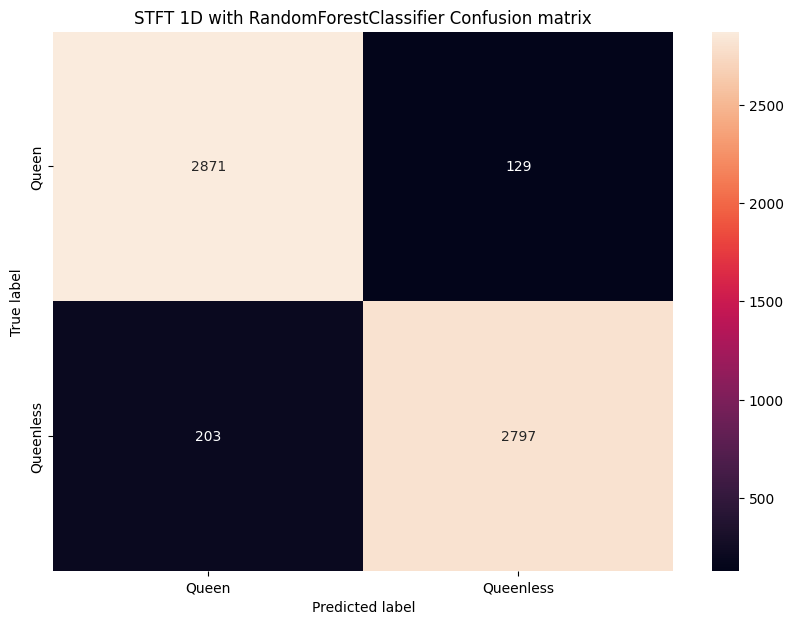

In [22]:
plot_confusion_matrix(cf_matrix, 'STFT 1D with RandomForestClassifier Confusion matrix')

In [23]:
def plot_roc_curve(Y_test, Y_pred, title):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

    auc = roc_auc_score(Y_test, Y_pred)

    plt.plot(fpr, tpr, label="ROC curve (area = {0:.2f})".format(auc))
    plt.plot([0, 1], [0, 1], linestyle="dashed")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(title + "_RandomSearch" + '.png')
    plt.show()

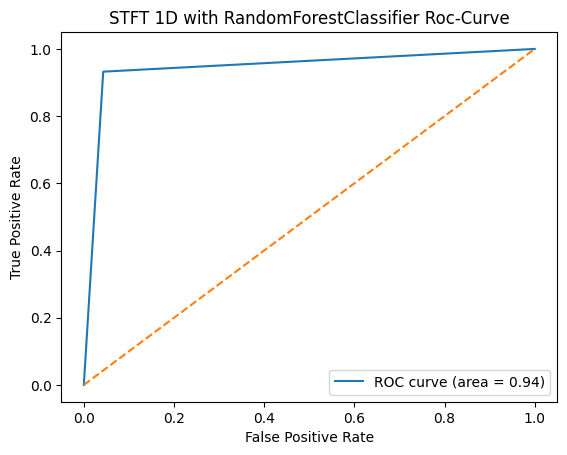

In [24]:
plot_roc_curve(Y_test, Y_pred, "STFT 1D with RandomForestClassifier Roc-Curve")

In [25]:
import pickle
pickle.dump(best_model, open("Random_search_RandomForestClassifier.pkl", "wb"))